In [ ]:
# Install dependencies
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install rarfile --quiet
!pip install stable-baselines3[extra] ale-py==0.7.4 --quiet
!pip install box2d-py --quiet
!pip install gym pyvirtualdisplay --quiet
!pip install pyglet==1.5.27 --quiet

     |████████████████████████████████| 170 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 51.9 MB/s 
     |████████████████████████████████| 1.5 MB 58.0 MB/s 
     |████████████████████████████████| 237 kB 64.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 6.7 MB/s 
     |████████████████████████████████| 448 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor

In [ ]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
nn_layers = [64,64] #This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
                    #If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

learning_rate = 0.001 #This is the step-size with which the gradient descent is carried out.
                      #Tip: Use smaller step-sizes for larger networks.

In [ ]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = gym.make('LunarLander-v2')
#You can also load other environments like cartpole, MountainCar, Acrobot. Refer to https://gym.openai.com/docs/ for descriptions.
#For example, if you would like to load Cartpole, just replace the above statement with "env = gym.make('CartPole-v1')".

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env,log_path = log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=64,  #for simplicity, we are not doing batch update.
            buffer_size=10000, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1, #learning starts immediately!
            gamma=0.99, #discount facto. range is between 0 and 1.
            tau = 0.001,  #the soft update coefficient for updating the target network
            target_update_interval=1, #update the target network immediately.
            train_freq=(1,"step"), #train the network at every step.
            max_grad_norm = 10, #the maximum value for the gradient clipping
            exploration_initial_eps = 0.5, #initial value of random action probability
            exploration_fraction = 0.05, #fraction of entire training period over which the exploration rate is reduced
            exploration_final_eps = 0.01,
            gradient_steps = 1, #number of gradient steps
            seed = 1, #seed for the pseudo random generators
            device = "cuda",
            verbose=0) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

# You can also experiment with other RL algorithms like A2C, PPO, DDPG etc. Refer to  https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
#for documentation. For example, if you would like to run DDPG, just replace "DQN" above with "DDPG".

In [ ]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break

# print(total_reward)
test_env.close()
show_video()

In [ ]:
model.learn(total_timesteps=160000, log_interval=10, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Eval num_timesteps=10000, episode_reward=137.38 +/- 109.23
Episode length: 383.60 +/- 335.38
Eval num_timesteps=20000, episode_reward=230.72 +/- 104.23
Episode length: 222.00 +/- 77.32
New best mean reward!
Eval num_timesteps=30000, episode_reward=148.22 +/- 67.37
Episode length: 676.00 +/- 396.89
Eval num_timesteps=40000, episode_reward=187.68 +/- 91.68
Episode length: 458.80 +/- 335.55
Eval num_timesteps=50000, episode_reward=254.54 +/- 12.41
Episode length: 256.60 +/- 101.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=205.73 +/- 104.46
Episode length: 362.40 +/- 213.99
Eval num_timesteps=70000, episode_reward=179.61 +/- 120.12
Episode length: 219.20 +/- 53.95
Eval num_timesteps=80000, episode_reward=206.28 +/- 107.25
Episode length: 214.20 +/- 18.76
Eval num_timesteps=90000, episode_reward=105.36 +/- 63.33
Episode length: 665.80 +/- 409.33
Eval num_timesteps=100000, episode_reward=201.80 +/- 95.57
Episode length: 362.00 +/- 320.21
Eval num_timesteps=110000, episod

In [ ]:
env = wrap_env(gym.make("LunarLander-v2"))
observation = env.reset()
while True:
  env.render()
  action, _states = model.predict(observation, deterministic=True)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

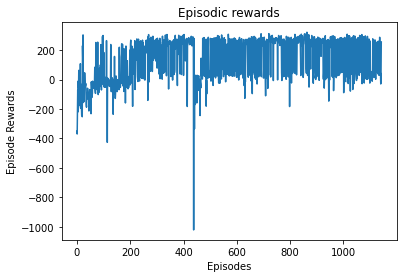

In [ ]:
from google.colab import files

x, y = ts2xy(load_results(log_dir), 'episodes')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.title("Episodic rewards")
plt.xlabel('Episodes')
plt.ylabel('Episode Rewards')
plt.savefig(fname="DQN.png")
files.download("DQN.png")